## Linear Models

In [1]:
from sklearn import datasets, linear_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
X, y = datasets.load_diabetes(return_X_y=True)
X_train, y_train = X[:-20], y[:-20]
X_test, y_test = X[-20:], y[-20:]

In [6]:
reg = linear_model.LinearRegression()

In [7]:
reg.fit(X_train, y_train)

LinearRegression()

In [17]:
print(f'coefficients: {reg.coef_}')

coefficients: [ 3.03499549e-01 -2.37639315e+02  5.10530605e+02  3.27736980e+02
 -8.14131709e+02  4.92814588e+02  1.02848452e+02  1.84606489e+02
  7.43519617e+02  7.60951722e+01]


In [9]:
y_pred = reg.predict(X_test)

In [10]:
print(f'mean squared error: {mean_squared_error(y_test, y_pred):.2f}')

mean squared error: 2004.57


In [11]:
print(f'r2_score: {r2_score(y_test, y_pred):.2f}')

r2_score: 0.59


The coefficient estimates for Ordinary Least Squares rely on the independence of the features. When features are correlated and the columns of the design matrix
have an approximate linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed target, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design.

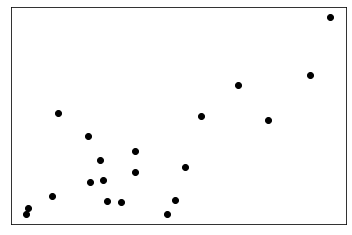

In [14]:
plt.scatter(X_test[:, np.newaxis, 2], y_test,  color='black')
#plt.plot(X_test[:, np.newaxis, 2], y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

##### Non-negative least squares
This may be usefule when the coefficients represents some physical or non-negative natural quantities.

In [ ]:
reg = linear_model.LinearRegression(positive=True)
# version 0.24

In [20]:
import sklearn
sklearn.__version__

'0.23.2'

## Ridge regression and classification

In [27]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)

reg.fit(X_train, y_train)

Ridge(alpha=0.5)

In [28]:
reg.coef_

array([  27.09629222, -127.42334878,  373.42781177,  243.7131328 ,
        -16.33945871,  -54.59187434, -174.91322631,  125.21982087,
        317.91451269,  117.06570716])

In [33]:
y_pred = reg.predict(X_test)

print(f'mean squared error: {mean_squared_error(y_test, y_pred)}')

print(f'r2: {r2_score(y_test, y_pred)}')

mean squared error: 2383.6469108600472
r2: 0.5066098181678838


Ridge classification: ridge regression (rr) is an estimator applied on highly ill-conditioned matrices where a slight change in the target variable can cause huge variances in the calculated weights. Therefore rr sets a certain regularization (alpha) to reduce this variation (noise).
the ridge_classifier can be significantly faster than logistic_regression with a high number of classes, because it is able to compute the projection matrix (XTX)-1 XT only once. This classifier is sometimes referred to as a Least Squares Support Vector Machines with a linear kernel.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm

In [39]:
X = 1./(np.arange(1,11) + np.arange(0,10)[:, np.newaxis])
y = np.ones(10)

In [43]:
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas) # (start, stop, num=50) Return numbers spaced evenly on a log scale.

coefs = []
for a in alphas:
    ridge = lm.Ridge(alpha=a, fit_intercept=False) # initialize a ridge regressor
    ridge.fit(X, y) # fit to data
    coefs.append(ridge.coef_) # get coefficients

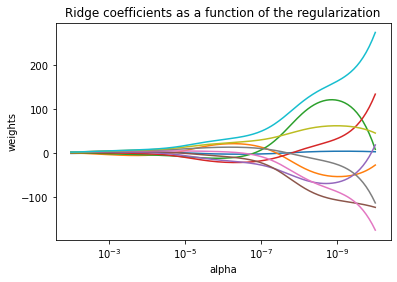

In [53]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

The Ridge regressor has a classifier variant: RidgeClassifier. This classifier first converts binary targets to {-1, 1} and then treats the problem as a regression task, optimizing the same objective as above. The predicted class corresponds to the sign of the regressor’s prediction. For multiclass classification, the problem is treated as multi-output regression, and the predicted class corresponds to the output with the highest value.

It might seem questionable to use a (penalized) Least Squares loss to fit a classification model instead of the more traditional logistic or hinge losses.

The RidgeClassifier can be significantly faster than e.g. LogisticRegression with a high number of classes, because it is able to compute the projection matrix
only once.

##### classification of text documents using sparse features
This is an example showing how scikit-learn can be used to classify documents by topics using a bag-of-words approach. This example uses a scipy.sparse matrix to store the features and demonstrates various classifiers that can efficiently handle sparse matrices.

In [1]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [3]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



##### Loading data

In [24]:
if opts.all_categories:
    categories = None
else:
    categories = ['alt.atheism',
                  'talk.religion.misc',
                  'comp.graphics',
                  'sci.space',]

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)

duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" % opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories

Extracting features from the training data using a sparse vectorizer
done in 0.388283s at 10.249MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.251910s at 11.383MB/s
n_samples: 1353, n_features: 33809



##### Benchmark Classifiers
Train and test the datasets with 15 different classification models and get performance results for each model.

In [27]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time
results = []

In [29]:
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(tol=0.01)
train time: 0.053s
test time:  0.003s
accuracy:   0.897
dimensionality: 33809
density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.022s
test time:  0.002s
accuracy:   0.888
dimensionality: 33809
density: 0.255302


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time: 0.036s
test time:  0.002s
accuracy:   0.906
dimensionality: 33809
density: 0.705337


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
train time: 0.001s
test time:  0.141s
accuracy:   0.858

Random forest
________________________________________________________________________________
Trainin

##### Plots

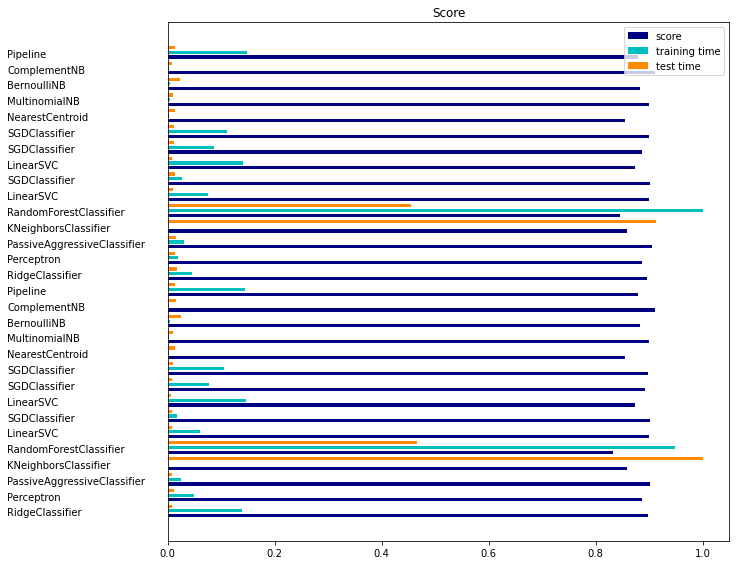

In [30]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time", color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()


In [ ]:
"""
==================================================================
Common pitfalls in interpretation of coefficients of linear models
==================================================================

In linear models, the target value is modeled as
a linear combination of the features (see the :ref:`linear_model` User Guide
section for a description of a set of linear models available in
scikit-learn).
Coefficients in multiple linear models represent the relationship between the
given feature, :math:`X_i` and the target, :math:`y`, assuming that all the
other features remain constant (`conditional dependence
<https://en.wikipedia.org/wiki/Conditional_dependence>`_).
This is different from plotting :math:`X_i` versus :math:`y` and fitting a
linear relationship: in that case all possible values of the other features are
taken into account in the estimation (marginal dependence).

This example will provide some hints in interpreting coefficient in linear
models, pointing at problems that arise when either the linear model is not
appropriate to describe the dataset, or when features are correlated.

We will use data from the `"Current Population Survey"
<https://www.openml.org/d/534>`_ from 1985 to predict
wage as a function of various features such as experience, age, or education.

.. contents::
   :local:
   :depth: 1
"""

print(__doc__)

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %%
# The dataset: wages
# ------------------
#
# We fetch the data from `OpenML <http://openml.org/>`_.
# Note that setting the parameter `as_frame` to True will retrieve the data
# as a pandas dataframe.

from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

# %%
# Then, we identify features `X` and targets `y`: the column WAGE is our
# target variable (i.e., the variable which we want to predict).
#
X = survey.data[survey.feature_names]
X.describe(include="all")

# %%
# Note that the dataset contains categorical and numerical variables.
# We will need to take this into account when preprocessing the dataset
# thereafter.

X.head()

# %%
# Our target for prediction: the wage.
# Wages are described as floating-point number in dollars per hour.
y = survey.target.values.ravel()
survey.target.head()

# %%
# We split the sample into a train and a test dataset.
# Only the train dataset will be used in the following exploratory analysis.
# This is a way to emulate a real situation where predictions are performed on
# an unknown target, and we don't want our analysis and decisions to be biased
# by our knowledge of the test data.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

# %%
# First, let's get some insights by looking at the variable distributions and
# at the pairwise relationships between them. Only numerical
# variables will be used. In the following plot, each dot represents a sample.
#
#   .. _marginal_dependencies:

train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

# %%
# Looking closely at the WAGE distribution reveals that it has a
# long tail. For this reason, we should take its logarithm
# to turn it approximately into a normal distribution (linear models such
# as ridge or lasso work best for a normal distribution of error).
#
# The WAGE is increasing when EDUCATION is increasing.
# Note that the dependence between WAGE and EDUCATION
# represented here is a marginal dependence, i.e., it describes the behavior
# of a specific variable without keeping the others fixed.
#
# Also, the EXPERIENCE and AGE are strongly linearly correlated.
#
# .. _the-pipeline:
#
# The machine-learning pipeline
# -----------------------------
#
# To design our machine-learning pipeline, we first manually
# check the type of data that we are dealing with:

survey.data.info()

# %%
# As seen previously, the dataset contains columns with different data types
# and we need to apply a specific preprocessing for each data types.
# In particular categorical variables cannot be included in linear model if not
# coded as integers first. In addition, to avoid categorical features to be
# treated as ordered values, we need to one-hot-encode them.
# Our pre-processor will
#
# - one-hot encode (i.e., generate a column by category) the categorical
#   columns;
# - as a first approach (we will see after how the normalisation of numerical
#   values will affect our discussion), keep numerical values as they are.

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR',
                       'MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns),
    remainder='passthrough'
)

# %%
# To describe the dataset as a linear model we use a ridge regressor
# with a very small regularization and to model the logarithm of the WAGE.


from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

# %%
# Processing the dataset
# ----------------------
#
# First, we fit the model.

_ = model.fit(X_train, y_train)

# %%
# Then we check the performance of the computed model plotting its predictions
# on the test set and computing,
# for example, the median absolute error of the model.

from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_train)

mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title('Ridge model, small regularization')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

# %%
# The model learnt is far from being a good model making accurate predictions:
# this is obvious when looking at the plot above, where good predictions
# should lie on the red line.
#
# In the following section, we will interpret the coefficients of the model.
# While we do so, we should keep in mind that any conclusion we draw is
# about the model that we build, rather than about the true (real-world)
# generative process of the data.
#
# Interpreting coefficients: scale matters
# ---------------------------------------------
#
# First of all, we can take a look to the values of the coefficients of the
# regressor we have fitted.

feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.concatenate(
    [feature_names, numerical_columns])

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)

coefs

# %%
# The AGE coefficient is expressed in "dollars/hour per living years" while the
# EDUCATION one is expressed in "dollars/hour per years of education". This
# representation of the coefficients has the benefit of making clear the
# practical predictions of the model: an increase of :math:`1` year in AGE
# means a decrease of :math:`0.030867` dollars/hour, while an increase of
# :math:`1` year in EDUCATION means an increase of :math:`0.054699`
# dollars/hour. On the other hand, categorical variables (as UNION or SEX) are
# adimensional numbers taking either the value 0 or 1. Their coefficients
# are expressed in dollars/hour. Then, we cannot compare the magnitude of
# different coefficients since the features have different natural scales, and
# hence value ranges, because of their different unit of measure. This is more
# visible if we plot the coefficients.

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# %%
# Indeed, from the plot above the most important factor in determining WAGE
# appears to be the
# variable UNION, even if our intuition might tell us that variables
# like EXPERIENCE should have more impact.
#
# Looking at the coefficient plot to gauge feature importance can be
# misleading as some of them vary on a small scale, while others, like AGE,
# varies a lot more, several decades.
#
# This is visible if we compare the standard deviations of different
# features.

X_train_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)

X_train_preprocessed.std(axis=0).plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev.')
plt.subplots_adjust(left=.3)

# %%
# Multiplying the coefficients by the standard deviation of the related
# feature would reduce all the coefficients to the same unit of measure.
# As we will see :ref:`after<scaling_num>` this is equivalent to normalize
# numerical variables to their standard deviation,
# as :math:`y = \sum{coef_i \times X_i} =
# \sum{(coef_i \times std_i) \times (X_i / std_i)}`.
#
# In that way, we emphasize that the
# greater the variance of a feature, the larger the weight of the corresponding
# coefficient on the output, all else being equal.

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# %%
# Now that the coefficients have been scaled, we can safely compare them.
#
# .. warning::
#
#   Why does the plot above suggest that an increase in age leads to a
#   decrease in wage? Why the :ref:`initial pairplot
#   <marginal_dependencies>` is telling the opposite?
#
# The plot above tells us about dependencies between a specific feature and
# the target when all other features remain constant, i.e., **conditional
# dependencies**. An increase of the AGE will induce a decrease
# of the WAGE when all other features remain constant. On the contrary, an
# increase of the EXPERIENCE will induce an increase of the WAGE when all
# other features remain constant.
# Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
# influence the model.
#
# Checking the variability of the coefficients
# --------------------------------------------
#
# We can check the coefficient variability through cross-validation:
# it is a form of data perturbation (related to
# `resampling <https://en.wikipedia.org/wiki/Resampling_(statistics)>`_).
#
# If coefficients vary significantly when changing the input dataset
# their robustness is not guaranteed, and they should probably be interpreted
# with caution.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

# %%
# The problem of correlated variables
# -----------------------------------
#
# The AGE and EXPERIENCE coefficients are affected by strong variability which
# might be due to the collinearity between the 2 features: as AGE and
# EXPERIENCE vary together in the data, their effect is difficult to tease
# apart.
#
# To verify this interpretation we plot the variability of the AGE and
# EXPERIENCE coefficient.
#
# .. _covariation:

plt.ylabel('Age coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title('Co-variations of coefficients for AGE and EXPERIENCE '
              'across folds')

# %%
# Two regions are populated: when the EXPERIENCE coefficient is
# positive the AGE one is negative and viceversa.
#
# To go further we remove one of the 2 features and check what is the impact
# on the model stability.

column_to_drop = ['AGE']

cv_model = cross_validate(
    model, X.drop(columns=column_to_drop), y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.drop(columns=column_to_drop).std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names[:-1]
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title('Coefficient importance and its variability')
plt.xlabel('Coefficient importance')
plt.subplots_adjust(left=.3)

# %%
# The estimation of the EXPERIENCE coefficient is now less variable and
# remain important for all models trained during cross-validation.
#
# .. _scaling_num:
#
# Preprocessing numerical variables
# ---------------------------------
#
# As said above (see ":ref:`the-pipeline`"), we could also choose to scale
# numerical values before training the model.
# This can be useful to apply a similar amount regularization to all of them
# in the Ridge.
# The preprocessor is redefined in order to subtract the mean and scale
# variables to unit variance.

from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)

# %%
# The model will stay unchanged.

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

_ = model.fit(X_train, y_train)

# %%
# Again, we check the performance of the computed
# model using, for example, the median absolute error of the model and the R
# squared coefficient.

y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title('Ridge model, small regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

# %%
# For the coefficient analysis, scaling is not needed this time.

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization, normalized variables')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# %%
# We now inspect the coefficients across several cross-validation folds.

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title('Coefficient variability')
plt.subplots_adjust(left=.3)

# %%
# The result is quite similar to the non-normalized case.
#
# Linear models with regularization
# ---------------------------------
#
# In machine-learning practice, Ridge Regression is more often used with
# non-negligible regularization.
#
# Above, we limited this regularization to a very little amount.
# Regularization improves the conditioning of the problem and reduces the
# variance of the estimates. RidgeCV applies cross validation in order to
# determine which value of the regularization parameter (`alpha`) is best
# suited for prediction.

from sklearn.linear_model import RidgeCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10, 10, 21)),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

_ = model.fit(X_train, y_train)

# %%
# First we check which value of :math:`\alpha` has been selected.

model[-1].regressor_.alpha_

# %%
# Then we check the quality of the predictions.

y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title('Ridge model, regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

# %%
# The ability to reproduce the data of the regularized model is similar to
# the one of the non-regularized model.

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, regularization, normalized variables')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# %%
# The coefficients are significantly different.
# AGE and EXPERIENCE coefficients are both positive but they now have less
# influence on the prediction.
#
# The regularization reduces the influence of correlated
# variables on the model because the weight is shared between the two
# predictive variables, so neither alone would have strong weights.
#
# On the other hand, the weights obtained with regularization are more
# stable  (see the :ref:`ridge_regression` User Guide section). This
# increased stability is visible from the plot, obtained from data
# perturbations, in a cross validation. This plot can  be compared with
# the :ref:`previous one<covariation>`.

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names
)

plt.ylabel('Age coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title('Co-variations of coefficients for AGE and EXPERIENCE '
              'across folds')

# %%
# Linear models with sparse coefficients
# --------------------------------------
#
# Another possibility to take into account correlated variables in the dataset,
# is to estimate sparse coefficients. In some way we already did it manually
# when we dropped the AGE column in a previous Ridge estimation.
#
# Lasso models (see the :ref:`lasso` User Guide section) estimates sparse
# coefficients. LassoCV applies cross validation in order to
# determine which value of the regularization parameter (`alpha`) is best
# suited for the model estimation.

from sklearn.linear_model import LassoCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=np.logspace(-10, 10, 21), max_iter=100000),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

_ = model.fit(X_train, y_train)

# %%
# First we verify which value of :math:`\alpha` has been selected.

model[-1].regressor_.alpha_

# %%
# Then we check the quality of the predictions.

y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title('Lasso model, regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

# %%
# For our dataset, again the model is not very predictive.

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Lasso model, regularization, normalized variables')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# %%
# A Lasso model identifies the correlation between
# AGE and EXPERIENCE and suppresses one of them for the sake of the prediction.
#
# It is important to keep in mind that the coefficients that have been
# dropped may still be related to the outcome by themselves: the model
# chose to suppress them because they bring little or no additional
# information on top of the other features. Additionnaly, this selection
# is unstable for correlated features, and should be interpreted with
# caution.
#
# Lessons learned
# ---------------
#
# * Coefficients must be scaled to the same unit of measure to retrieve
#   feature importance. Scaling them with the standard-deviation of the
#   feature is a useful proxy.
# * Coefficients in multivariate linear models represent the dependency
#   between a given feature and the target, **conditional** on the other
#   features.
# * Correlated features induce instabilities in the coefficients of linear
#   models and their effects cannot be well teased apart.
# * Different linear models respond differently to feature correlation and
#   coefficients could significantly vary from one another.
# * Inspecting coefficients across the folds of a cross-validation loop
#   gives an idea of their stability.
